In [1]:
import torch
import d2l

In [3]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5),
                  cmap='Reds'):
    """
    为了可视化注意力权重，我们定义下面函数以显示矩阵热图

    :matrices: 的形状为(要显示的行数,要显示的列数,查询的数目,键的数目)
    :titles: 可选参数，为每列子图设置标题
    :cmap: 热力图的颜色映射，默认'Reds'（红色系）
    """
    d2l.use_svg_display()
    num_rows, num_cols = matrices.shape[0], matrices.shape[1]
    """
    squeeze=False 确保 axes 始终为二维数组（避免行列数为 1 时降维）

    :fig: Figure对象，控制着图形的全局属性（如大小、标题、背景色等）
    :axes: Axes对象数组，每个元素对应着一个子图的坐标轴（如 axes[0,0] 代表第一行第一列的子图），用于索引具体的子图
           例如， axes[i,j].plot(x,y) 为绘制索引为(i,j)的子图
    """
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize,
                                 sharex=True, sharey=True, squeeze=False)
    """
    zip(axes, matrices) 将 axes（二维子图对象数组）和 matrices（四维数据矩阵）按行配对
        假设 axes 形状为 (num_rows,num_cols)， matrices 形状为 (num_rows, num_cols, ...)
        则 zip 生成 num_rows 个元组，每个元组包含 axes 的一行和 matrices 的一行
    enumerate(zip(axes, matrices)) 为每一行的 zip 结果添加索引 i（从0开始）

    (row_axes, row_matrices) 对 enumerate(zip(axes, matrices)) 解包：
        i 为索引
        row_axes 为 axes 的第 i 行
        row_matrices 为 matrices 的第 i 行，形状为(要显示的列数,查询的数目,键的数目)
    """
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(d2l.numpy(matrix), cmap=cmap)
            # 设置轴标签，仅最后一行和第一列需设置
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=axes, shrink=0.6)

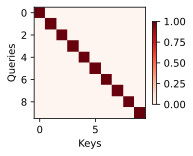

In [5]:
# torch.eye(rows) 生成单位矩阵。
attention_weights = d2l.reshape(d2l.eye(10), (1, 1, 10, 10))
# 这个 attention_weights 的意义在于，当且仅当 Queries 等于 Keys，weights 值为1，否则为0
show_heatmaps(attention_weights, xlabel='Keys', ylabel='Queries')

In [8]:
import torch
from torch import nn
import d2l

In [13]:
n_train = 50  # 训练样本数
x_train, _ = torch.sort(d2l.rand(n_train) * 5)   # 排序后的训练样本
x_train

tensor([0.0246, 0.0922, 0.1054, 0.1617, 0.1915, 0.3051, 0.3334, 0.3611, 0.4802,
        0.7198, 0.8962, 1.1167, 1.1435, 1.2309, 1.3200, 1.3973, 1.4138, 1.4331,
        1.6953, 1.7059, 1.7504, 1.7715, 1.7846, 1.8794, 1.9894, 2.2783, 2.6194,
        2.6719, 2.8382, 2.9740, 3.2020, 3.3583, 3.3710, 3.6274, 3.7010, 3.7598,
        4.0662, 4.0737, 4.1314, 4.2077, 4.5096, 4.5102, 4.5997, 4.6420, 4.7468,
        4.8020, 4.8035, 4.8996, 4.9163, 4.9301])

In [14]:
def f(x):
    return 2 * d2l.sin(x) + x**0.8

y_train = f(x_train) + d2l.normal(0.0, 0.5, (n_train,))  # 训练样本的输出
x_test = d2l.arange(0, 5, 0.1)  # 测试样本
y_truth = f(x_test)  # 测试样本的真实输出
n_test = len(x_test)  # 测试样本数
n_test

50

In [15]:
def plot_kernel_reg(y_hat):
    d2l.plot(x_test, [y_truth, y_hat], 'x', 'y', legend=['Truth', 'Pred'],
             xlim=[0, 5], ylim=[-1, 5])
    d2l.plt.plot(x_train, y_train, 'o', alpha=0.5);

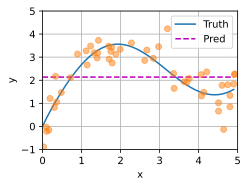

In [16]:
y_hat = torch.repeat_interleave(y_train.mean(), n_test)
plot_kernel_reg(y_hat)

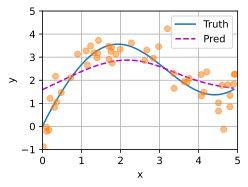

In [17]:
# X_repeat的形状:(n_test,n_train),
# 每一行都包含着相同的测试输入（例如：同样的查询）
X_repeat = d2l.reshape(x_test.repeat_interleave(n_train), (-1, n_train))
# x_train包含着键。attention_weights的形状：(n_test,n_train),
# 每一行都包含着要在给定的每个查询的值（y_train）之间分配的注意力权重
attention_weights = nn.functional.softmax(-(X_repeat - x_train)**2 / 2, dim=1)
# y_hat的每个元素都是值的加权平均值，其中的权重是注意力权重
y_hat = d2l.matmul(attention_weights, y_train)
plot_kernel_reg(y_hat)

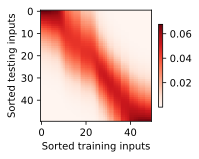

In [18]:
d2l.show_heatmaps(attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [19]:
"""
对 n 个 a*b 矩阵 {X1, ..., Xn} 和 n 个 b*c 矩阵 {Y1, ..., Yn}
bnn 提供批量矩阵乘法，返回 (n,a,c) 大小的 {X1*Y1, ..., Xn*Yn}
"""
X = d2l.ones((2, 1, 4))
Y = d2l.ones((2, 4, 6))
torch.bmm(X, Y).shape

torch.Size([2, 1, 6])

In [21]:
# 在注意力机制的背景中，我们可以使用小批量矩阵乘法来计算小批量数据中的加权平均值。
weights = d2l.ones((2, 10)) * 0.1
values = d2l.reshape(d2l.arange(20.0), (2, 10))
# (2,1,10) * (2,10,1) = (2,1,1)
torch.bmm(weights.unsqueeze(1), values.unsqueeze(-1))

tensor([[0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000],
        [0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000, 0.1000,
         0.1000]])
tensor([[ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.],
        [10., 11., 12., 13., 14., 15., 16., 17., 18., 19.]])


tensor([[[ 4.5000]],

        [[14.5000]]])

In [22]:
class NWKernelRegression(nn.Module):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.w = nn.Parameter(torch.rand((1,), requires_grad=True))

    def forward(self, queries, keys, values):
        # queries和attention_weights的形状为(查询个数，“键－值”对个数)
        queries = d2l.reshape(
            queries.repeat_interleave(keys.shape[1]), (-1, keys.shape[1]))
        self.attention_weights = nn.functional.softmax(
            -((queries - keys) * self.w)**2 / 2, dim=1)
        # values的形状为(查询个数，“键－值”对个数)
        return torch.bmm(self.attention_weights.unsqueeze(1),
                         values.unsqueeze(-1)).reshape(-1)

In [23]:
# X_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输入
X_tile = x_train.repeat((n_train, 1))
# Y_tile的形状:(n_train，n_train)，每一行都包含着相同的训练输出
Y_tile = y_train.repeat((n_train, 1))
# keys的形状:('n_train'，'n_train'-1)
keys = d2l.reshape(X_tile[(1 - d2l.eye(n_train)).type(torch.bool)],
                   (n_train, -1))
# values的形状:('n_train'，'n_train'-1)
values = d2l.reshape(Y_tile[(1 - d2l.eye(n_train)).type(torch.bool)],
                     (n_train, -1))

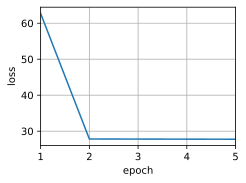

In [24]:
net = NWKernelRegression()
# 使用平方损失
loss = nn.MSELoss(reduction='none')
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, 5])

for epoch in range(5):
    trainer.zero_grad()
    l = loss(net(x_train, keys, values), y_train)
    l.sum().backward()
    trainer.step()
    print(f'epoch {epoch + 1}, loss {float(l.sum()):.6f}')
    animator.add(epoch + 1, float(l.sum()))

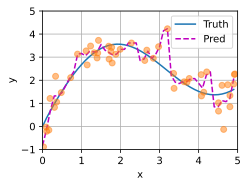

In [25]:
# keys的形状:(n_test，n_train)，每一行包含着相同的训练输入（例如，相同的键）
keys = x_train.repeat((n_test, 1))
# value的形状:(n_test，n_train)
values = y_train.repeat((n_test, 1))
y_hat = net(x_test, keys, values).unsqueeze(1).detach()
plot_kernel_reg(y_hat)

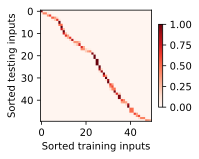

In [26]:
d2l.show_heatmaps(net.attention_weights.unsqueeze(0).unsqueeze(0),
                  xlabel='Sorted training inputs',
                  ylabel='Sorted testing inputs')

In [27]:
import d2l
import math
import torch
from torch import nn

In [28]:
def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    # X:3D张量，valid_lens:1D或2D张量
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # 最后一轴上被掩蔽的元素使用一个非常大的负值替换，从而其softmax输出为0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

In [36]:
masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))

tensor([[[0.4795, 0.5205, 0.0000, 0.0000],
         [0.4155, 0.5845, 0.0000, 0.0000]],

        [[0.4205, 0.2837, 0.2958, 0.0000],
         [0.4343, 0.2453, 0.3204, 0.0000]]])

In [37]:
# 也可以使用二维张量，为矩阵样本中的每一行指定有效长度
masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.2343, 0.4857, 0.2800, 0.0000]],

        [[0.6562, 0.3438, 0.0000, 0.0000],
         [0.1305, 0.3222, 0.2631, 0.2842]]])

In [38]:
# 加性注意力
class AdditiveAttention(nn.Module):
    """加性注意力"""
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        """
        在 unsqueeze 维度扩展后，
        queries的形状：(batch_size，num_queries，1，num_hidden)
        key的形状：(batch_size，1，num_kv_pairs，num_hiddens)
        根据广播规则：
        - queries 的第3维会被复制 nom_kv_pairs 次
        - keys 第第2维会被复制 num_queries 次
        接着，二者逐元素相加
        """
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # self.w_v仅有一个输出，因此从形状中移除最后那个维度。
        # scores的形状：(batch_size，查询的个数，“键-值”对的个数)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # values的形状：(batch_size，“键－值”对的个数，值的维度)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [39]:
# 形状为(批量大小,步数,特征大小)，分别为(2,1,20)和(2,10,2)
queries, keys = d2l.normal(0, 1, (2, 1, 20)), d2l.ones((2, 10, 2))
# values的小批量，两个值矩阵是相同的
values = torch.arange(40, dtype=torch.float32).reshape(1, 10, 4).repeat(
    2, 1, 1)
valid_lens = d2l.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)

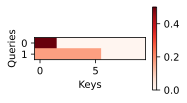

In [40]:
d2l.show_heatmaps(d2l.reshape(attention.attention_weights, (1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [41]:
class DotProductAttention(nn.Module):
    """缩放点积注意力"""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # queries的形状：(batch_size，查询的个数，d)
    # keys的形状：(batch_size，“键－值”对的个数，d)
    # values的形状：(batch_size，“键－值”对的个数，值的维度)
    # valid_lens的形状:(batch_size，)或者(batch_size，查询的个数)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # 设置transpose_b=True为了交换keys的最后两个维度
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [42]:
queries = d2l.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

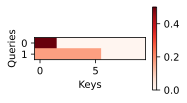

In [43]:
d2l.show_heatmaps(d2l.reshape(attention.attention_weights, (1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

In [44]:
import torch
from torch import nn
import d2l

In [46]:
class AttentionDecoder(d2l.Decoder):
    """带有注意力机制解码器的基本接口"""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

In [47]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers,
            dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # outputs的形状为(batch_size，num_steps，num_hiddens).
        # hidden_state的形状为(num_layers，batch_size，num_hiddens)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # enc_outputs的形状为(batch_size,num_steps,num_hiddens).
        # hidden_state的形状为(num_layers,batch_size, num_hiddens)
        enc_outputs, hidden_state, enc_valid_lens = state
        # 输出X的形状为(num_steps,batch_size,embed_size)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:
            # query的形状为(batch_size,1,num_hiddens)
            query = torch.unsqueeze(hidden_state[-1], dim=1)
            # context的形状为(batch_size,1,num_hiddens)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens)
            # 在特征维度上连结
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # 将x变形为(1,batch_size,embed_size+num_hiddens)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # 全连接层变换后，outputs的形状为
        # (num_steps,batch_size,vocab_size)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In [48]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = d2l.zeros((4, 7), dtype=torch.long)  # (batch_size,num_steps)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

loss 0.019, 4289.8 tokens/sec on mps:0


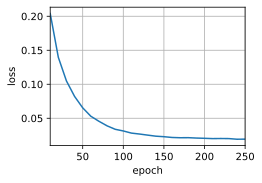

In [49]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [50]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => elle est <unk> .,  bleu 0.000
i'm home . => je suis chez moi .,  bleu 1.000


In [56]:
attention_weights = d2l.reshape(
    d2l.concat([step[0][0][0] for step in dec_attention_weight_seq], 0),
    (1, 1, -1, num_steps))

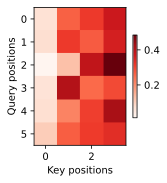

In [57]:
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

In [58]:
import d2l
import math
import torch
from torch import nn

In [59]:
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)

    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        # output的形状:(batch_size*num_heads，查询的个数，
        # num_hiddens/num_heads)
        output = self.attention(queries, keys, values, valid_lens)

        # output_concat的形状:(batch_size，查询的个数，num_hiddens)
        output_concat = transpose_output(output, self.num_heads)
        return self.W_o(output_concat)

In [60]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads，
    # num_hiddens/num_heads)
    X = X.reshape(X.shape[0], X.shape[1], num_heads, -1)

    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)

    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数,
    # num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])


def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

In [61]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [62]:
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens =  6, d2l.tensor([3, 2])
X = d2l.ones((batch_size, num_queries, num_hiddens))
Y = d2l.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape

torch.Size([2, 4, 100])

In [63]:
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的P
        self.P = d2l.zeros((1, max_len, num_hiddens))
        X = d2l.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

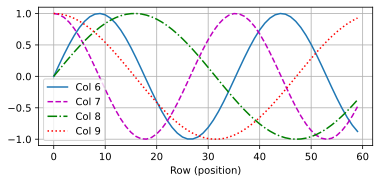

In [64]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(d2l.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(d2l.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in d2l.arange(6, 10)])

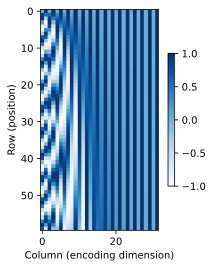

In [65]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                  ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')

In [66]:
for i in range(8):
    print(f'{i}的二进制是：{i:>03b}')

0的二进制是：000
1的二进制是：001
2的二进制是：010
3的二进制是：011
4的二进制是：100
5的二进制是：101
6的二进制是：110
7的二进制是：111


In [67]:
import d2l
import math
import pandas as pd
import torch
from torch import nn

In [68]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [71]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
print(ffn(d2l.ones((2, 3, 4))))

tensor([[[ 0.3746, -0.6508,  0.8960,  0.3088, -0.5674,  0.1814,  0.1521,
          -0.4818],
         [ 0.3746, -0.6508,  0.8960,  0.3088, -0.5674,  0.1814,  0.1521,
          -0.4818],
         [ 0.3746, -0.6508,  0.8960,  0.3088, -0.5674,  0.1814,  0.1521,
          -0.4818]],

        [[ 0.3746, -0.6508,  0.8960,  0.3088, -0.5674,  0.1814,  0.1521,
          -0.4818],
         [ 0.3746, -0.6508,  0.8960,  0.3088, -0.5674,  0.1814,  0.1521,
          -0.4818],
         [ 0.3746, -0.6508,  0.8960,  0.3088, -0.5674,  0.1814,  0.1521,
          -0.4818]]], grad_fn=<ViewBackward0>)


In [72]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = d2l.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [73]:
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [74]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(d2l.ones((2, 3, 4)), d2l.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [75]:
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [76]:
# transfomer 编码器中的任何层都不会改变其输入的形状
X = d2l.ones((2, 100, 24))
valid_lens = d2l.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [77]:
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [78]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(d2l.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [81]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理，
        # 因此state[2][self.i]初始化为None。
        # 预测阶段，输出序列是通过词元一个接着一个解码的，
        # 因此state[2][self.i]包含着直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),
            # 其中每一行是[1,2,...,num_steps]
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器－解码器注意力。
        # enc_outputs的开头:(batch_size,num_steps,num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

In [82]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = d2l.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [83]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

loss 0.031, 6565.5 tokens/sec on mps:0


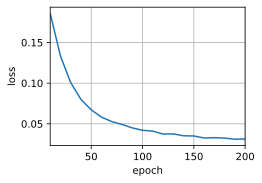

In [84]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [85]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est paresseux .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [86]:
enc_attention_weights = d2l.reshape(
    d2l.concat(net.encoder.attention_weights, 0),
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

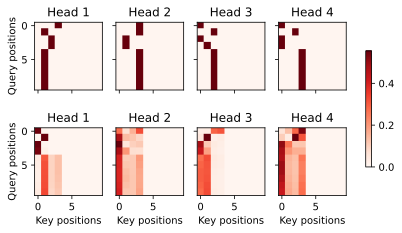

In [87]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [88]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = d2l.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = d2l.reshape(dec_attention_weights_filled,
                                (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

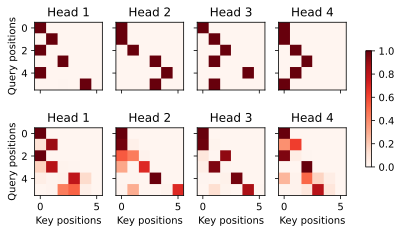

In [89]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

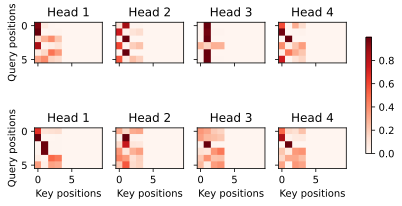

In [90]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))